# Time-series Anomaly Detection
This demo shows how to use a novel SLS (Streaming Least Squares) anomaly detection algorithm and how it performs


In [1]:
%pylab inline
rcParams['figure.figsize'] = [16, 3]
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from AnomalyDetection import detect_anomalies

___
### Example 1: Detect spikes

First, let's take a quick look at our sample time-series data file, which consists of 2 columns: datetime and counter value, aggregated every 15 minutes.

In [3]:
df = pd.read_csv('data/sample1.csv', parse_dates=True, index_col=0)
data = df['Counter']
data.head(10)

Date
2014-08-31 15:15:00    800
2014-08-31 15:30:00    685
2014-08-31 15:45:00    642
2014-08-31 16:00:00    637
2014-08-31 16:15:00    648
2014-08-31 16:30:00    802
2014-08-31 16:45:00    804
2014-08-31 17:00:00    814
2014-08-31 17:15:00    646
2014-08-31 17:30:00    628
Name: Counter, dtype: int64

,level,start,end,score
0,5,2014-09-08 22:15:00,2014-09-09 03:00:00,9827.845647
1,4,2014-09-09 17:45:00,2014-09-09 22:30:00,8545.505790
2,3,2014-10-20 16:00:00,2014-10-20 20:45:00,6579.968928
3,2,2014-10-23 08:45:00,2014-10-23 13:30:00,4118.137916
4,1,2014-10-24 16:00:00,2014-10-24 20:45:00,3370.247811
5,1,2014-10-22 15:45:00,2014-10-22 20:30:00,2739.181531
6,1,2014-10-02 11:45:00,2014-10-02 16:30:00,2548.604885
7,1,2014-09-08 17:15:00,2014-09-08 22:00:00,2012.427544
8,1,2014-10-23 14:00:00,2014-10-23 18:45:00,1992.001427
9,1,2014-11-05 00:45:00,2014-11-05 05:30:00,1892.816077


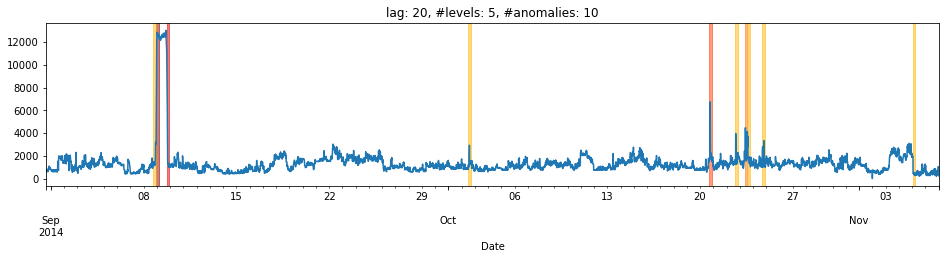

In [4]:
anomalies, thresholds = detect_anomalies(data, lag=20, num_anomalies=10)

___________
### Example 2: Detect dips

In the above, SLS was able to detect spikes in the series. The same algorithm can be used for detecting dips as well, e.g. outages (sudden drop in sessions server).

In [5]:
df = pd.read_csv('data/sample2.csv', parse_dates=True, index_col=0)
data = df['Value']

,level,start,end,score
0,1,2018-03-05 16:00:00,2018-03-10 00:00:00,30.396664


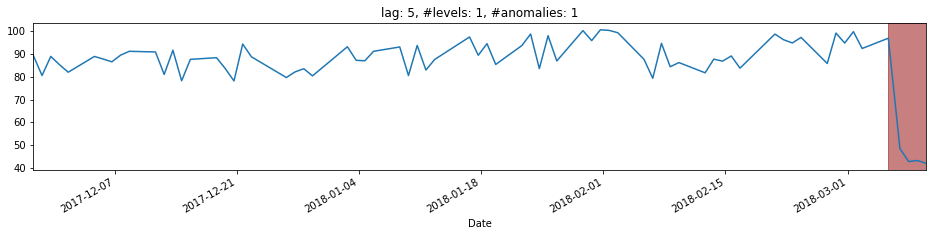

In [6]:
anomalies, thresholds = detect_anomalies(data, lag=5, num_anomalies=1)

_____

## Model deployment for real-time anomaly detection

The demo here is for evaluting the effectiveness of the algorithm on historical data. To deploy the model for **real-time** detection on streaming data, follow this C++ API.

<pre>    <span style=' color: Blue;'>typedef</span> <span style=' color: Blue;'>std</span>::vector&lt;<span style=' color: Blue;'>float</span>&gt; FloatVec; 

    <span style=' color: Blue;'>class</span> AnomalyDetector { 
    <span style=' color: Blue;'>public</span>: 
        <span style=' color: Green;'>/// Alert Thresholds, which can be updated (if needed) live without breaking the service</span>
        FloatVec Thresholds; 

        <span style=' color: Green;'>/// Instantiate the detector from window size and Thresholds</span>
        AnomalyDetector(<span style=' color: Blue;'>int</span> windowSize, FloatVec&gt;&amp; thresholds); 

        <span style=' color: Green;'>/// Instantiate the detector from a saved model file</span> 
        AnomalyDetector(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelFile);
         
        <span style=' color: Green;'>/// Save the detector to a model file</span> 
        <span style=' color: Blue;'>void</span> Save(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelFile);
         
        <span style=' color: Green;'>/// Predict takes an incoming counter value and returns the alert level (0 means no anomaly).</span> 
        <span style=' color: Green;'>/// It also produces auxiliary outputs such as trend and the anomaly score </span>
        <span style=' color: Blue;'>int</span> Predict(<span style=' color: Blue;'>float</span> value, <span style=' color: Blue;'>float</span>&amp; trend, <span style=' color: Blue;'>float</span>&amp; score);
    };</pre>

1. Instantiate the anomaly detector from the model file.
2. Then, for each new counter value, call *Predict* to get the alert level as well as the trend and anomaly score.

### Bulk Predict
We also provide a bulk predict API for handling multiple signals in parallel (via *OpenMP*).
<pre>    <span style=' color: Blue;'>class</span> BulkAnomalyDetector { 
9se    <span style=' color: Blue;'>public</span>: 
        <span style=' color: Blue;'>std</span>::vector&lt;FloatVec&gt; Thresholds; 

        <span style=' color: Green;'>/// Instantiate the detectors from a zipped container of model files</span>
        BulkAnomalyDetector(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelsContainerFile);

        <span style=' color: Blue;'>std</span>::vector&lt;<span style=' color: Blue;'>int</span>&gt; BulkPredict(<span style=' color: Blue;'>const</span> FloatVec&amp; value, FloatVec&amp; trends, FloatVec&amp; scores);
    }; 
</pre>